In [ ]:
!pip install numpy pandas matplotlib seaborn scikit-learn

In [ ]:
from google.colab import files
files.upload() #kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d sukhmandeepsinghbrar/car-price-prediction-dataset
!unzip car-price-prediction-dataset.zip 

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [ ]:
#loading the data and partial cleanup
df = pd.read_csv("cardekho.csv").dropna();

df['brand'] = df['name'].str.split(' ').str[0]
df['model'] = df['name'].str.split(' ').str[1:].str.join(' ')
df = df.drop(columns = ["mileage(km/ltr/kg)","name","seller_type","seats","max_power"])
df = df.iloc[::1]
df.columns = df.columns.str.replace(" ", "_") # adjusting column names
display(df.head())      # first 5 rows
df.shape                 # how many rows x columns
df.info()                # data types + non-null counts
df.describe().T          # summary statistics for numeric features


,year,selling_price,km_driven,fuel,transmission,owner,engine,brand,model
0,2014,450000,145500,Diesel,Manual,First Owner,1248.0,Maruti,Swift Dzire VDI
1,2014,370000,120000,Diesel,Manual,Second Owner,1498.0,Skoda,Rapid 1.5 TDI Ambition
2,2006,158000,140000,Petrol,Manual,Third Owner,1497.0,Honda,City 2017-2020 EXi
3,2010,225000,127000,Diesel,Manual,First Owner,1396.0,Hyundai,i20 Sportz Diesel
4,2007,130000,120000,Petrol,Manual,First Owner,1298.0,Maruti,Swift VXI BSIII


<class 'pandas.core.frame.DataFrame'>
Index: 7907 entries, 0 to 8127
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           7907 non-null   int64  
 1   selling_price  7907 non-null   int64  
 2   km_driven      7907 non-null   int64  
 3   fuel           7907 non-null   object 
 4   transmission   7907 non-null   object 
 5   owner          7907 non-null   object 
 6   engine         7907 non-null   float64
 7   brand          7907 non-null   object 
 8   model          7907 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 617.7+ KB


,count,mean,std,min,25%,50%,75%,max
year,7907.0,2013.982168,3.866650,1994.0,2012.0,2015.0,2017.0,2020.0
selling_price,7907.0,649741.656380,813556.530537,29999.0,270000.0,450000.0,690000.0,10000000.0
km_driven,7907.0,69192.556469,56789.761602,1.0,35000.0,60000.0,95750.0,2360457.0
engine,7907.0,1458.625016,503.916303,624.0,1197.0,1248.0,1582.0,3604.0


## Numeric features distribution

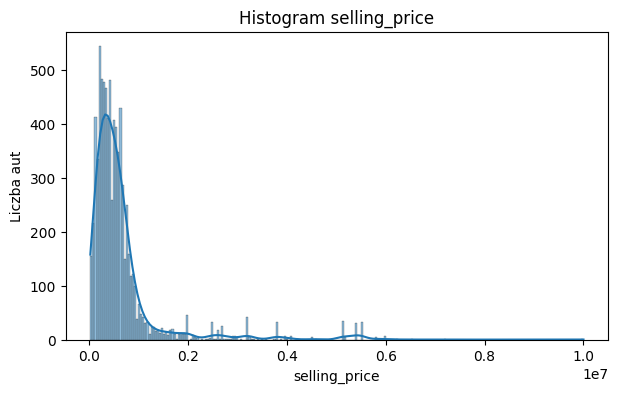

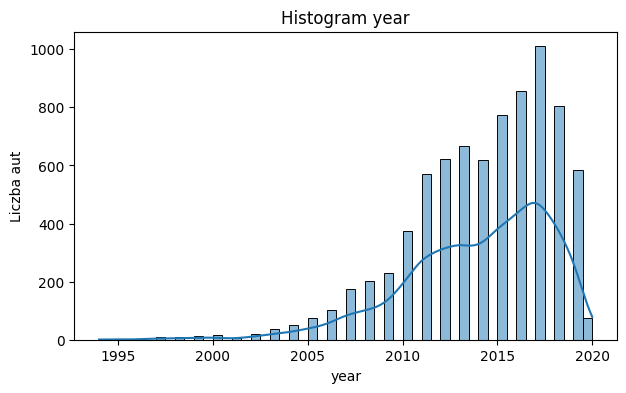

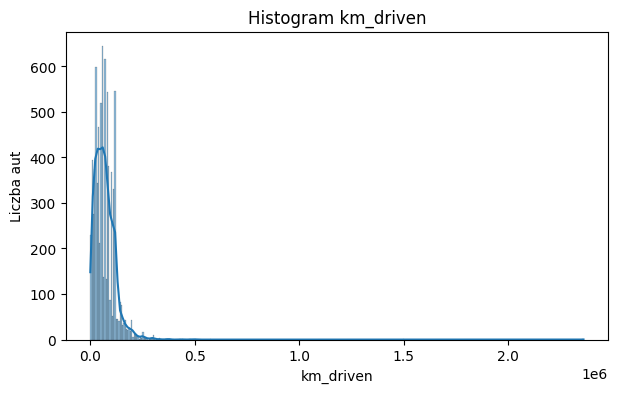

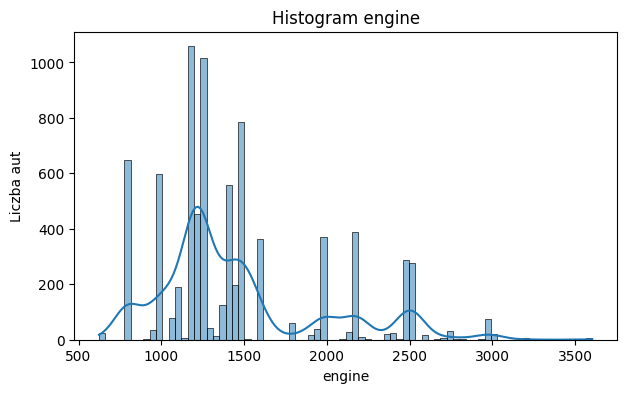

In [217]:
num_cols = ['selling_price','year',  'km_driven', 'engine']

for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Histogram {col}')
    plt.xlabel(col)
    plt.ylabel('Liczba aut')
    plt.show()

## Correlation heatmap for numeric features


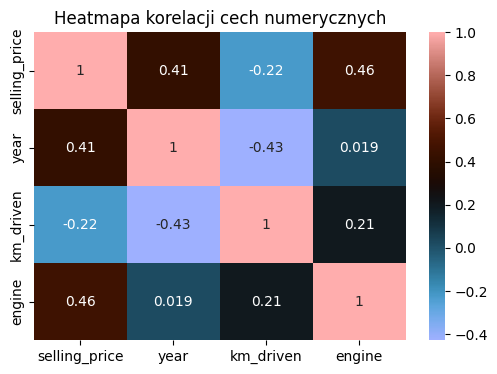

In [218]:

corr = df[num_cols].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='berlin')
plt.title('Heatmapa korelacji cech numerycznych')
plt.show()


### Scatterplots price vs numeric feature

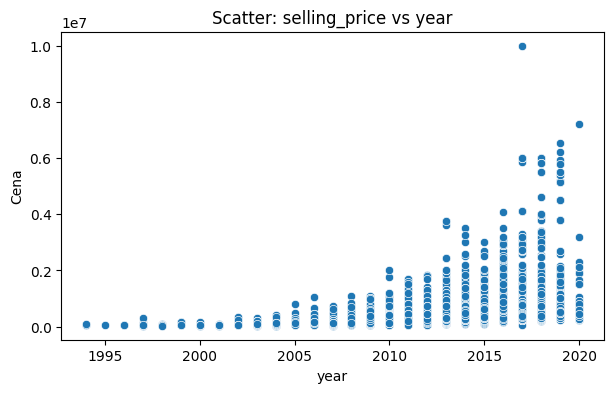

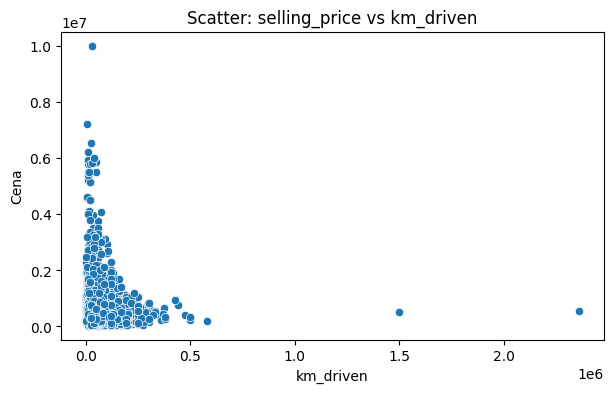

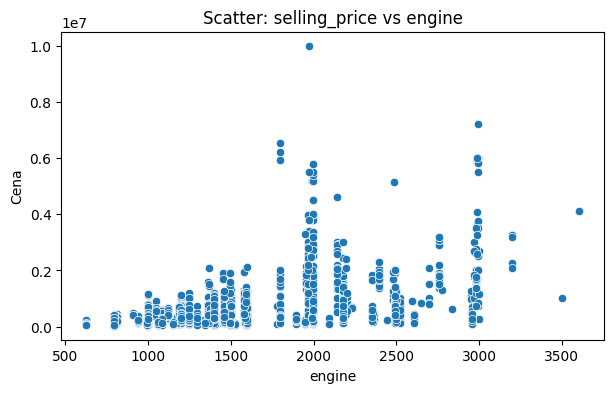

In [202]:
for col in ['year', 'km_driven', 'engine']:
    plt.figure(figsize=(7,4))
    sns.scatterplot(x=df[col], y=df['selling_price'])
    plt.title(f'Scatter: selling_price vs {col}')
    plt.xlabel(col)
    plt.ylabel('Cena')
    plt.show()

## Categorical features counts

In [203]:
print(df["fuel"].value_counts())
print(df["transmission"].value_counts())
print(df["owner"].value_counts())

fuel
Diesel    4299
Petrol    3520
CNG         53
LPG         35
Name: count, dtype: int64
transmission
Manual       6866
Automatic    1041
Name: count, dtype: int64
owner
First Owner             5215
Second Owner            2017
Third Owner              510
Fourth & Above Owner     160
Test Drive Car             5
Name: count, dtype: int64


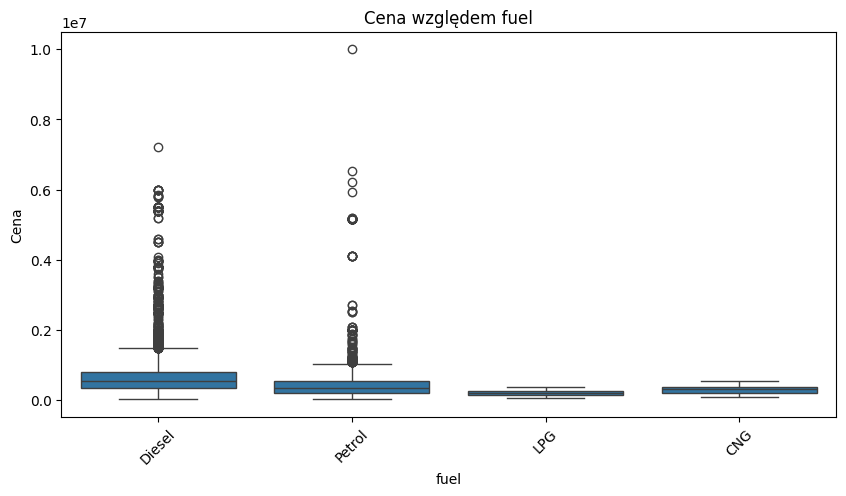

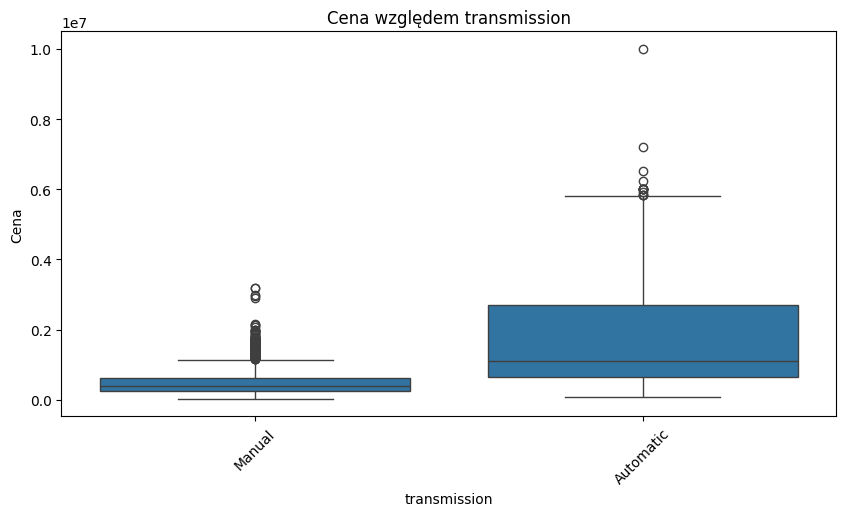

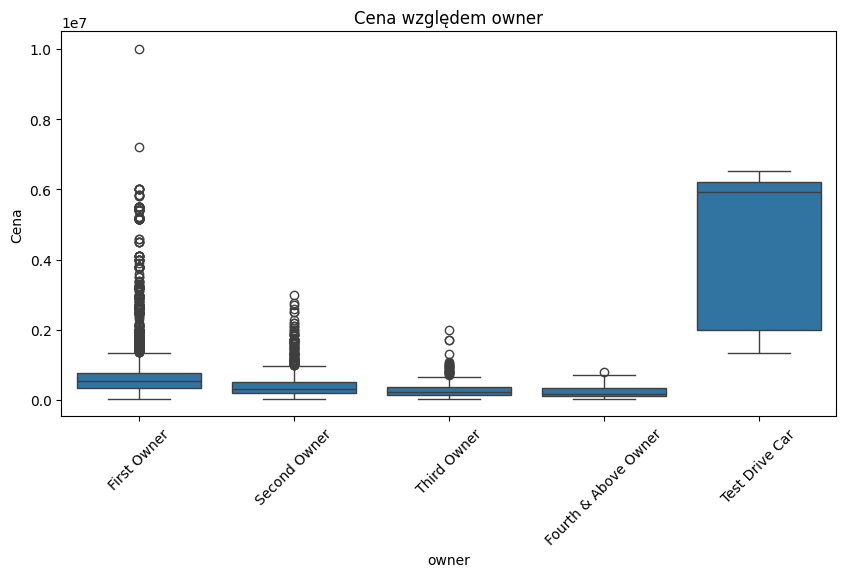

In [204]:
for cat in ['fuel', 'transmission', 'owner']:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=df[cat], y=df['selling_price'])
    plt.title(f'Cena względem {cat}')
    plt.xlabel(cat)
    plt.ylabel('Cena')
    plt.xticks(rotation=45)
    plt.show()


In [205]:
X = df.drop(columns=["selling_price"]) 
y = df["selling_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42) # train/test split

In [ ]:
numeric_features = ["year", "engine", "km_driven"]
categorical_features = ["brand", "fuel", "transmission",  "model","owner"] # "Condition",

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

## Baseline models

### Random Forest Baseline

In [207]:
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("rf", RandomForestRegressor(random_state=42))
])
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)


### SVR baseline

In [208]:
svr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("svr", SVR(kernel="rbf"))
])
svr_pipeline.fit(X_train, y_train)
y_pred_svr = svr_pipeline.predict(X_test)

### MLPRegressor baseline

In [209]:
mlp_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("mlp", MLPRegressor(random_state=42, solver="adam", early_stopping=True))
    #("mlp", MLPRegressor(random_state=42, solver="lbfgs", max_iter=1000))
])
mlp_pipeline.fit(X_train, y_train)
y_pred_mlp = mlp_pipeline.predict(X_test)

### Baseline evaluation

In [210]:
def evaluate(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred) # mean absolute error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) # root mean squared error
    r2 = r2_score(y_true, y_pred) # r2 score
    return pd.Series([name, mae, rmse, r2], index=["Model", "MAE", "RMSE", "R2"])

results = pd.DataFrame([
    evaluate("RandomForest(default)", y_test, y_pred_rf),
    evaluate("SVR(default)",        y_test, y_pred_svr),
    evaluate("MLP(default)",        y_test, y_pred_mlp)
])
display(results)

,Model,MAE,RMSE,R2
0,RandomForest(default),67961.975449,1.387482e+05,0.974248
1,SVR(default),399399.932037,8.892683e+05,-0.057840
2,MLP(default),658929.023077,1.087068e+06,-0.580768


## Hyperparameter tuning

In [211]:
param_grids = {
    "rf": {
        "rf__n_estimators": [100, 200, 300, 500],                
        "rf__max_depth": [None, 10, 15, 20, 30],              
        "rf__min_samples_leaf": [1, 2],         
        "rf__min_samples_split": [2, 5, 10], 
        "rf__max_features": ["sqrt", 0.5, 0.7, None],           
        "rf__bootstrap": [True, False]
    },
    "svr": {
        "svr__kernel": ["linear", "rbf"],
        "svr__C": [0.1, 1, 10, 100],
        "svr__gamma": [0.01, 0.1, 1, "scale", "auto"]
    },
    "mlp": {
        "mlp__hidden_layer_sizes": [(64,), (128,64)],
        "mlp__activation": ["relu", "tanh"],
        "mlp__alpha": [1e-3, 1e-4],
        "mlp__learning_rate_init": [0.001, 0.01],
        "mlp__solver": ["adam", "lbfgs"],
        "mlp__early_stopping": [True]
    }
}

searches = {}

In [ ]:
# Random Forest search
searches["rf_search"] = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_grids["rf"],
    n_iter=50,  # number of random combinations to try
    cv=5,  # 5-fold cross-validation
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

# SVR Search
searches["svr_search"] = RandomizedSearchCV(
    estimator=svr_pipeline,
    param_distributions=param_grids["svr"],
    n_iter=50,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)

# MLP Search
searches["mlp_search"] = RandomizedSearchCV(
    estimator=mlp_pipeline,
    param_distributions=param_grids["mlp"],
    n_iter=50,
    cv=5,
    scoring="neg_root_mean_squared_error",
    random_state=42,
    n_jobs=-1
)



### Running the searches

In [ ]:
searches["rf_search"].fit(X_train, y_train);
searches["svr_search"].fit(X_train, y_train);
searches["mlp_search"].fit(X_train, y_train);

best_rf = searches["rf_search"].best_estimator_
best_svr = searches["svr_search"].best_estimator_
best_mlp = searches["mlp_search"].best_estimator_

In [214]:
for name in ["rf_search", "svr_search", "mlp_search"]:
    print(f"Best parameters for {name}:")
    print(searches[name].best_params_)
    print("-" * 40)

Best parameters for rf_search:
{'rf__n_estimators': 200, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_features': 0.5, 'rf__max_depth': 30, 'rf__bootstrap': False}
----------------------------------------
Best parameters for svr_search:
{'svr__kernel': 'linear', 'svr__gamma': 0.01, 'svr__C': 100}
----------------------------------------
Best parameters for mlp_search:
{'mlp__solver': 'lbfgs', 'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (128, 64), 'mlp__early_stopping': True, 'mlp__alpha': 0.0001, 'mlp__activation': 'relu'}
----------------------------------------


In [215]:
final_results = []
for name, model in [("RF_tuned", best_rf),
                    ("SVR_tuned", best_svr),
                    ("MLP_tuned", best_mlp)]:
    y_pred = model.predict(X_test)
    final_results.append(evaluate(name, y_test, y_pred))

display(pd.DataFrame(final_results).sort_values("RMSE"))

,Model,MAE,RMSE,R2
0,RF_tuned,64673.779974,125659.696477,0.978877
2,MLP_tuned,83664.793258,129217.091035,0.977665
1,SVR_tuned,283614.839567,762994.596884,0.221251


In [220]:
# Step 1: Evaluate default models
rf_default = evaluate("RandomForest", y_test, y_pred_rf)
svr_default = evaluate("SVR", y_test, y_pred_svr)
mlp_default = evaluate("MLP", y_test, y_pred_mlp)

# Step 2: Evaluate tuned models
rf_tuned = evaluate("RandomForest", y_test, best_rf.predict(X_test))
svr_tuned = evaluate("SVR", y_test, best_svr.predict(X_test))
mlp_tuned = evaluate("MLP", y_test, best_mlp.predict(X_test))


comparison_df = pd.DataFrame({
    "Model": ["RF", "SVR", "MLP"],
    
    "MAE_default": [round(rf_default["MAE"]), round(svr_default["MAE"]), round(mlp_default["MAE"])],
    "MAE_tuned": [round(rf_tuned["MAE"]), round(svr_tuned["MAE"]), round(mlp_tuned["MAE"])],
    "MAE_diff": [round(rf_default["MAE"] - rf_tuned["MAE"]),
                 round(svr_default["MAE"] - svr_tuned["MAE"]),
                 round(mlp_default["MAE"] - mlp_tuned["MAE"])],
    "MAE_%diff": [round((rf_default["MAE"] - rf_tuned["MAE"]) / rf_default["MAE"] * 100, 2),
                  round((svr_default["MAE"] - svr_tuned["MAE"]) / svr_default["MAE"] * 100, 2),
                  round((mlp_default["MAE"] - mlp_tuned["MAE"]) / mlp_default["MAE"] * 100, 2)],

    "RMSE_default": [round(rf_default["RMSE"]), round(svr_default["RMSE"]), round(mlp_default["RMSE"])],
    "RMSE_tuned": [round(rf_tuned["RMSE"]), round(svr_tuned["RMSE"]), round(mlp_tuned["RMSE"])],
    "RMSE_diff": [round(rf_default["RMSE"] - rf_tuned["RMSE"]),
                  round(svr_default["RMSE"] - svr_tuned["RMSE"]),
                  round(mlp_default["RMSE"] - mlp_tuned["RMSE"])],
    "RMSE_%diff": [round((rf_default["RMSE"] - rf_tuned["RMSE"]) / rf_default["RMSE"] * 100, 2),
                   round((svr_default["RMSE"] - svr_tuned["RMSE"]) / svr_default["RMSE"] * 100, 2),
                   round((mlp_default["RMSE"] - mlp_tuned["RMSE"]) / mlp_default["RMSE"] * 100, 2)],

    "R2_default": [round(rf_default["R2"],5), round(svr_default["R2"],5),round (mlp_default["R2"],5)],
    "R2_tuned": [round(rf_tuned["R2"],5), round(svr_tuned["R2"],5), round(mlp_tuned["R2"],5)],
    "R2_diff": [round(rf_tuned["R2"] - rf_default["R2"],5),
                round(svr_tuned["R2"] - svr_default["R2"],5),
                round(mlp_tuned["R2"] - mlp_default["R2"],5)],
    "R2_%diff": [round((rf_tuned["R2"] - rf_default["R2"]) / abs(rf_default["R2"]) * 100, 2),
                 round((svr_tuned["R2"] - svr_default["R2"]) / abs(svr_default["R2"]) * 100, 2),
                 round((mlp_tuned["R2"] - mlp_default["R2"]) / abs(mlp_default["R2"]) * 100, 2)],
})


display(comparison_df)


,Model,MAE_default,MAE_tuned,MAE_diff,MAE_%diff,RMSE_default,RMSE_tuned,RMSE_diff,RMSE_%diff,R2_default,R2_tuned,R2_diff,R2_%diff
0,RF,67962,64674,3288,4.84,138748,125660,13089,9.43,0.97425,0.97888,0.00463,0.48
1,SVR,399400,283615,115785,28.99,889268,762995,126274,14.20,-0.05784,0.22125,0.27909,482.52
2,MLP,658929,83665,575264,87.30,1087068,129217,957851,88.11,-0.58077,0.97766,1.55843,268.34
